# Diffraction Pattern Indexing with VAE

This notebook demonstrates how to use the `DiffractionPatternIndexer` to encode diffraction patterns into a latent space and retrieve their crystallographic orientations. The indexer uses a combination of:

1. A variational autoencoder (VAE) model to encode patterns into a latent representation
2. A vector database (ChromaDB) to efficiently store and retrieve latent vectors and their orientations

## Setup

First, let's load the necessary modules and configure auto-reloading for code changes.

In [1]:
import os
import sys

# When notebook/ and latice/ are siblings, you need to add the parent directory
# which contains both folders to the path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time
import torch

from latice.index.dp_indexer import DiffractionPatternIndexer, IndexerConfig
from latice.index.chroma_db import LatentVectorDatabaseConfig, LatentVectorDatabase
from latice.model import VariationalAutoEncoderRawData

## Initialise the Indexer

Now let's set up the indexer with the VAE model and a ChromaDB vector database. The indexer will automatically:
1. Load the diffraction patterns and orientation data
2. Encode the patterns into the latent space
3. Build a searchable database of latent vectors and their orientations

In [3]:
# Latent vector database config
collection_name = "test"
persist_directory = ".chroma_db"
pattern_path = Path("../data/sample_pattern.npy")
angles_path = Path("../data/anglefile_sample.txt")
dimension = 16
device = "mps"

# Indexer config
model_path = "../checkpoints/vae-best.pt"
batch_size = 64
random_seed = 42
image_size = (128, 128)
top_n = 10
orientation_threshold = 3.0

In [4]:
# Initialise the vector database
db = LatentVectorDatabase(
    config=LatentVectorDatabaseConfig(
        collection_name=collection_name,
        persist_directory=persist_directory,
        dimension=dimension,
    )
)

# Initialise the VAE model
model = VariationalAutoEncoderRawData()
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint)
model.eval()

# Initialise the indexer
indexer = DiffractionPatternIndexer(
    model=model,
    db=db,
    config=IndexerConfig(
        pattern_path=pattern_path,
        angles_path=angles_path,
        batch_size=batch_size,
        device=device,
        latent_dim=dimension,
        random_seed=random_seed,
        image_size=image_size,
        top_n=top_n,
        orientation_threshold=orientation_threshold,
    ),
)
indexer.build_dictionary()

2025-04-08 23:23:06,454 - chromadb.telemetry.product.posthog - INFO - Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
2025-04-08 23:23:06,543 - latice.index.chroma_db - INFO - Created persistent ChromaDB at .chroma_db
2025-04-08 23:23:06,544 - latice.index.chroma_db - INFO - Retrieved existing collection 'test'
2025-04-08 23:23:06,665 - latice.index.dp_indexer - INFO - Using device: mps
2025-04-08 23:23:06,683 - latice.data_module - INFO - Loaded diffraction pattern data from ../data/sample_pattern.npy
2025-04-08 23:23:06,690 - latice.data_module - INFO - Dataset initialized with 625 samples
2025-04-08 23:23:06,691 - latice.data_module - INFO - Test dataset prepared with 625 samples
2025-04-08 23:23:06,691 - latice.index.dp_indexer - INFO - Generating latent vectors from patterns in ../data/sample_pattern.npy


Output()

2025-04-08 23:23:17,450 - latice.index.dp_indexer - INFO - Adding 625 vectors to database
2025-04-08 23:23:17,467 - latice.index.chroma_db - INFO - Adding 625 vectors to collection 'test' in 1 batches


Output()

2025-04-08 23:23:17,633 - latice.index.chroma_db - INFO - Successfully added 625 vectors to the database


## Explore the Data

Let's take a look at the diffraction patterns and their orientations:

Patterns shape: torch.Size([64, 1, 128, 128])
Orientations shape: torch.Size([64, 3])


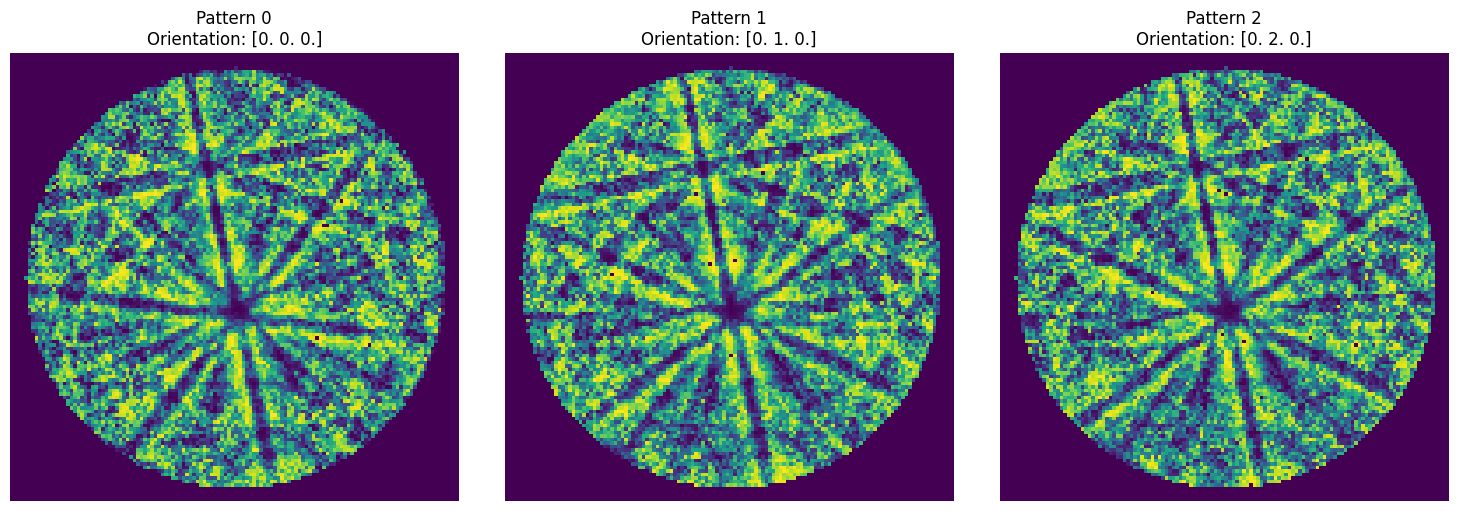

In [5]:
# Load a sample batch from the dataloader
dataloader = indexer._create_dataloader
sample_batch = next(iter(dataloader))
patterns, orientations = sample_batch

# Display the shape of the data
print(f"Patterns shape: {patterns.shape}")
print(f"Orientations shape: {orientations.shape}")

# Visualise a few patterns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    axes[i].imshow(patterns[i].squeeze(), cmap='viridis')
    axes[i].set_title(f"Pattern {i}\nOrientation: {orientations[i].numpy()}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

## Indexing Single Patterns

Now let's index a single diffraction pattern and examine the results:

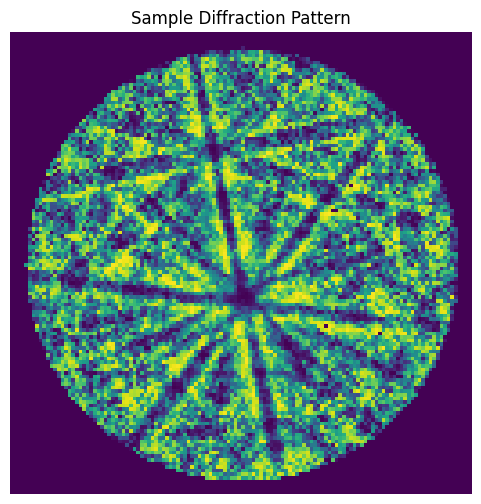

Indexed pattern in 0.2151 seconds
angles: [0. 0. 0.]
Best orientation: [[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0. 75.  0.]
 [ 0. 75.  0.]
 [ 0. 75.  0.]]
Success: True


/Users/andrewtung/Documents/Github/ebsd-vae/latice/index/dp_indexer.py:213: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  orientation = self.db.find_best_orientation(


In [6]:
# Load a sample pattern
# sample_pattern = np.load("../data/N=100_noised.npy")[50]
sample_pattern, angles = indexer._create_dataloader.dataset[0]
sample_pattern = sample_pattern.squeeze()

# Display the pattern
fig, axs = plt.subplots(1, 1, figsize=(6, 6))
axs.imshow(sample_pattern, cmap="viridis")
axs.set_title("Sample Diffraction Pattern")
axs.axis("off")
plt.show()

# Time the indexing operation
start_time = time.time()
orientation_result = indexer.index_pattern(
    pattern=sample_pattern, top_n=20, orientation_threshold=3.0
)
end_time = time.time()

print(f"Indexed pattern in {end_time - start_time:.4f} seconds")
print(f"angles: {angles}")
print(f"Best orientation: {orientation_result.get_top_n_orientations(10)}")
print(f"Success: {orientation_result.success}")

## The Latent Space Representation

We can also examine the latent vector representation of a pattern:

Latent vector dimension: (16,)
Latent vector: [ 0.464253    1.6969917   0.25944105  1.3006036   3.6085017   1.6216437
  1.4556384   0.02762707  1.1068585   1.5457656   0.14775133  1.3858962
  0.16503672 -1.9133785   0.59439623 -0.13531281]


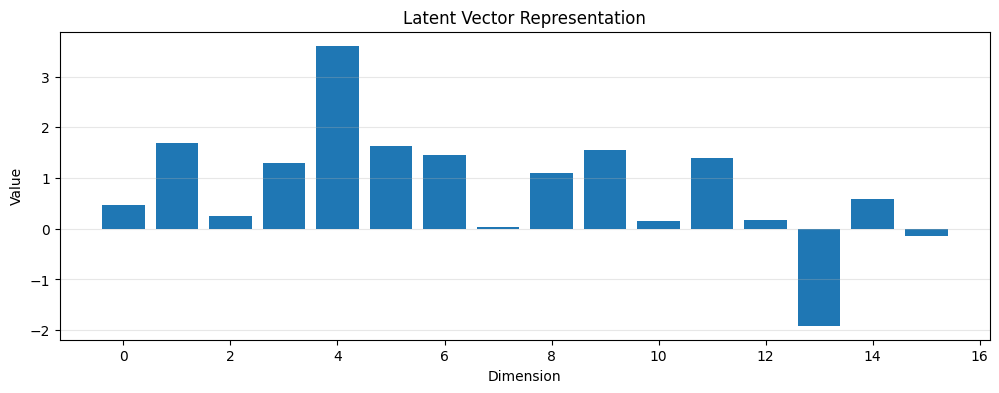

In [7]:
# Encode the pattern to get its latent representation
latent_vector = indexer.encode_pattern(sample_pattern)
print(f"Latent vector dimension: {latent_vector.shape}")
print(f"Latent vector: {latent_vector}")

fig, axs = plt.subplots(1, 1, figsize=(12, 4))
axs.bar(range(len(latent_vector)), latent_vector)
axs.set_xlabel("Dimension")
axs.set_ylabel("Value")
axs.set_title("Latent Vector Representation")
axs.grid(axis="y", alpha=0.3)
plt.show()

## Batch Processing

For efficiency, the indexer also supports batch processing of multiple patterns:

Output()

2025-04-08 23:27:53,437 - latice.index.chroma_db - WARNING - Failed to find best orientation after 3 iterations


Indexed 5 patterns in 0.6664 seconds
Average time per pattern: 0.1333 seconds

Results summary:
Pattern 0: None (success: False)
Pattern 1: [ 180.            5.23053717 -180.        ] (success: True)
Pattern 2: [-180.            9.90876064  180.        ] (success: True)
Pattern 3: [0.         6.04744462 0.        ] (success: True)
Pattern 4: [ 0.         60.88466824  0.        ] (success: True)


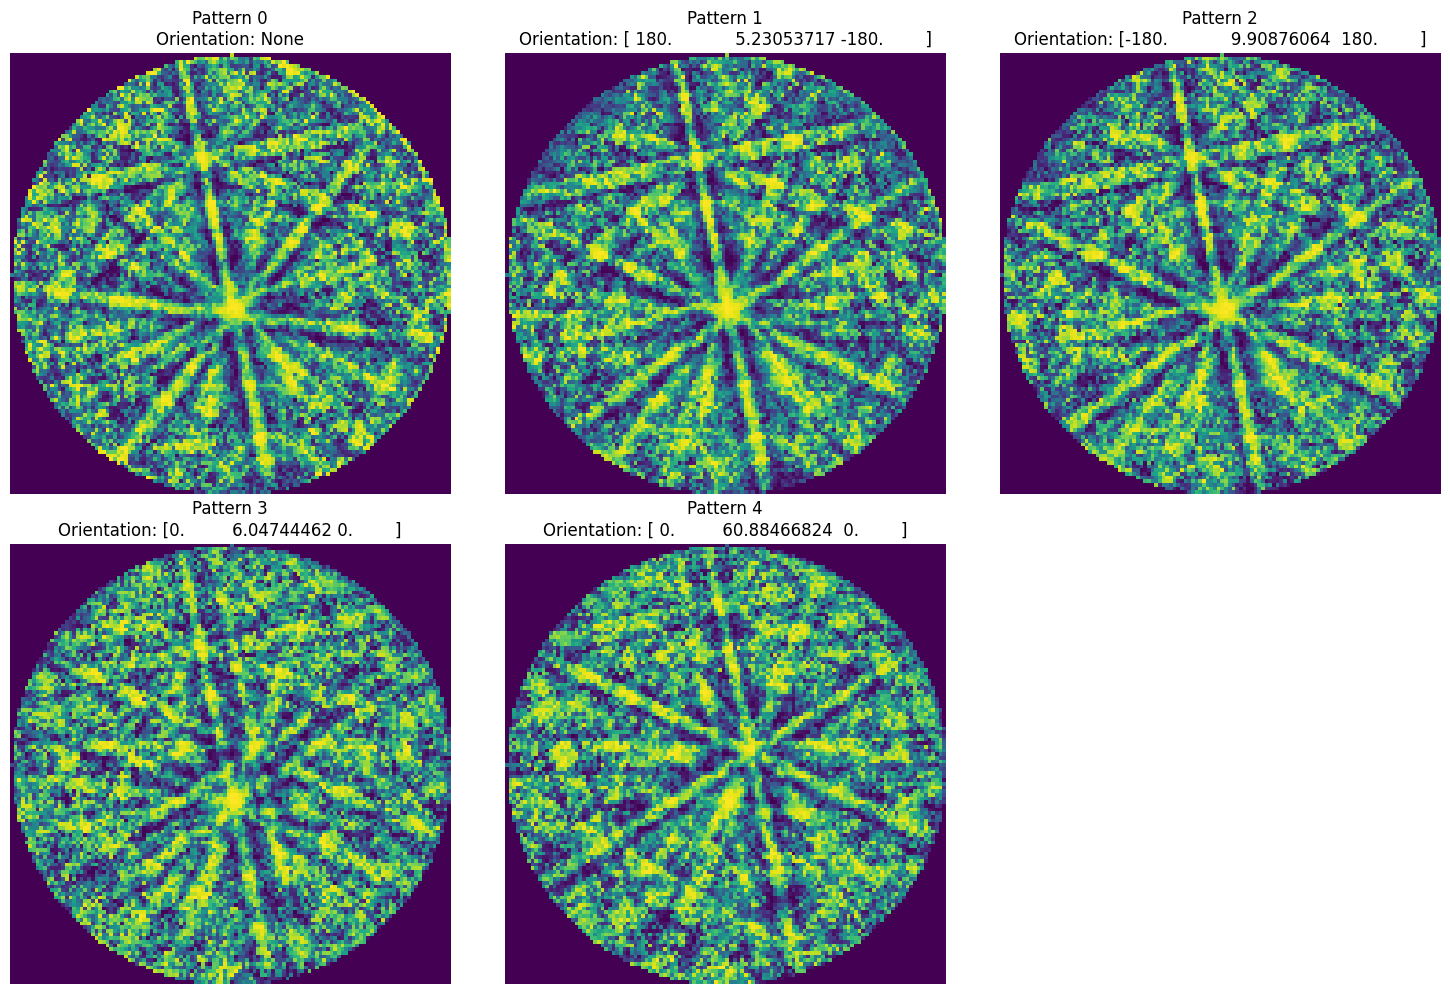

In [12]:
# Load multiple patterns
batch_patterns = np.load("../data/sample_pattern.npy")[:5]

# Time batch indexing
start_time = time.time()
orientation_results = indexer.index_patterns_batch(batch_patterns)
end_time = time.time()

print(f"Indexed {len(batch_patterns)} patterns in {end_time - start_time:.4f} seconds")
print(
    f"Average time per pattern: {(end_time - start_time) / len(batch_patterns):.4f} seconds"
)

print("\nResults summary:")
for i, result in enumerate(orientation_results):
    print(f"Pattern {i}: {result.mean_orientation} (success: {result.success})")

# Visualise the orientations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(5):
    axes[i].imshow(batch_patterns[i], cmap="viridis")
    axes[i].set_title(
        f"Pattern {i}\nOrientation: {orientation_results[i].mean_orientation}"
    )
    axes[i].axis("off")

fig.delaxes(axes[5])
plt.tight_layout()
plt.show()